In [39]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
print("TensorFlow: ", tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from PIL import Image


TensorFlow:  2.17.0


In [5]:
def save_video_frames(video_path, output_dir, frame_rate=150):
    """
    Read a video and save its frames to a specified directory.
    
    Parameters:
    - video_path: str, path to the input video.
    - output_dir: str, directory where frames will be saved.
    - how many frames you want to save "1" means everything
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Open the video file
    video_capture = cv.VideoCapture(video_path)
    
    # Check if the video opened successfully
    if not video_capture.isOpened():
        print(f"Error opening video file: {video_path}")
        return
    
    # Get the total number of frames in the video
    total_frames = int(video_capture.get(cv.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in the video: {total_frames}")
    
    frame_number = 0
    
    while True:
        # Read a frame from the video
        ret, frame = video_capture.read()
        
        # If the frame was not read correctly, exit the loop
        if not ret:
            break
        
        if frame_number % frame_rate == 0:
            # Construct the output filename
            frame_filename = os.path.join(output_dir, f"frame_{frame_number:04d}.jpg")
                
            # Save the frame as a JPEG file
            cv.imwrite(frame_filename, frame)
            print(f"Saved frame {frame_number} to {frame_filename}")
            
        # Increment the frame number
        frame_number += 1
    
    # Release the video capture object
    video_capture.release()
    print(f"Frames have been saved to: {output_dir}")

In [6]:
save_video_frames(video_path="data/grasrobot.mp4", output_dir="frames/", frame_rate=150)

Total frames in the video: 8326
Saved frame 0 to frames/frame_0000.jpg
Saved frame 150 to frames/frame_0150.jpg
Saved frame 300 to frames/frame_0300.jpg
Saved frame 450 to frames/frame_0450.jpg
Saved frame 600 to frames/frame_0600.jpg
Saved frame 750 to frames/frame_0750.jpg
Saved frame 900 to frames/frame_0900.jpg
Saved frame 1050 to frames/frame_1050.jpg
Saved frame 1200 to frames/frame_1200.jpg
Saved frame 1350 to frames/frame_1350.jpg
Saved frame 1500 to frames/frame_1500.jpg
Saved frame 1650 to frames/frame_1650.jpg
Saved frame 1800 to frames/frame_1800.jpg
Saved frame 1950 to frames/frame_1950.jpg
Saved frame 2100 to frames/frame_2100.jpg
Saved frame 2250 to frames/frame_2250.jpg
Saved frame 2400 to frames/frame_2400.jpg
Saved frame 2550 to frames/frame_2550.jpg
Saved frame 2700 to frames/frame_2700.jpg
Saved frame 2850 to frames/frame_2850.jpg
Saved frame 3000 to frames/frame_3000.jpg
Saved frame 3150 to frames/frame_3150.jpg
Saved frame 3300 to frames/frame_3300.jpg
Saved frame

In [40]:
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    # Load the image from disk and normalize 
    img = load_img(image_path, target_size=(224, 224))  # Resize to 224x224 for ResNet
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)  # Preprocess for ResNet
    return np.array(img_array)

In [42]:
def build_resnet_encoder(input_shape=(64, 64, 3), latent_dim=2):
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg') 
    encoder = Model(inputs=base_model.input, outputs=base_model.output)  
    return encoder

In [44]:
# Step 1 read frames
dir_path = "frames/"
files = os.listdir(dir_path)

# frames = np.array([cv.cvtColor(cv.imread(dir_path + x), cv.COLOR_BGR2RGB) for x in files])
frames = np.array([load_and_preprocess_image(dir_path + x) for x in files])

# Step 2 Define the encoder model
encoder = build_resnet_encoder()

# Step 3: Encode the extracted frames
embeddings = encoder.predict(frames)

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step


In [47]:
print(len(embeddings[50]))

2048


In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(embeddings)

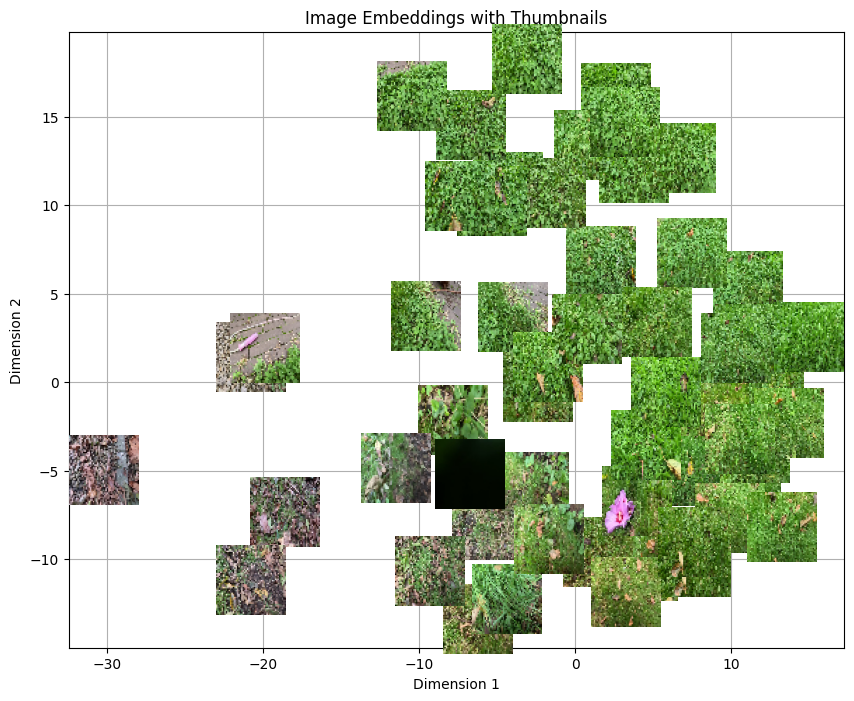

In [63]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Assuming pca_results contains the 2D reduced embeddings
# and image_paths contains the file paths of the images.

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Loop through each point and add the corresponding thumbnail
for idx, point in enumerate(pca_results):
    x, y = point[0], point[1]
    
    # Add a transparent scatter point (optional)
    plt.scatter(x, y, alpha=0)  # Hide the original points
    
    # Load and create thumbnail for the image
    img = load_img(dir_path + files[idx], target_size=(50, 50))  # Resize thumbnail
    imagebox = OffsetImage(img, zoom=1.0)  # Adjust zoom as needed
    
    # Create an annotation box with the thumbnail
    ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0.1)
    
    # Add the annotation box to the plot
    plt.gca().add_artist(ab)

plt.title("Image Embeddings with Thumbnails")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid()
plt.show()